## This is my attempt at implementing the RouBl algorithm using layer-wise updates

In [13]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm

In [28]:
class FullCovGaussianLayer(nn.Module):
    """Represents a full covariance Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_params = input_dim * output_dim + output_dim
        # Prior parameters p(theta)
        prior_std = 0.8 ### we can later add this as a parameter
        # prior_std = 1.1 ### we can later add this as a parameter

        mu_prior = torch.ones(input_dim * output_dim + output_dim)/20 # prior mean for all weights and biases
        cov_chol_prior = torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim) * prior_std

        self.register_buffer('prior_mean', mu_prior)
        self.register_buffer('prior_weight_cov_chol', cov_chol_prior)
        self.register_buffer('prior_cov_inv', 1/prior_std**2 * torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim))  

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = mu_prior
        self.cov_chol = cov_chol_prior

        # initialise lambda (not sure where this is used)
        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean


        # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl
    
    ## Maybe this instead wants to be in the network class and get passed to forward for each layer...might be neater
    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        """Propagates x through this layer by sampling weights from the posterior"""
        # assert (len(input.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        # assert input.shape[-1] == self.input_dim

        # num_samples = x.shape[0]

        weights = sampled_params[:self.input_dim * self.output_dim].view(self.output_dim, self.input_dim)
        biases = sampled_params[self.input_dim * self.output_dim:]
        return F.linear(input, weights, biases)
        # # rsample carries out reparameterisation trick for us   
        # weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # return x @ weights + biases # (num_samples, batch_size, output_dim).


In [29]:
class FullCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(FullCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
    
        self.network = nn.ModuleList()

        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation)
    
    def sample_network_params(self):
        """
        Sample parameters for each layer and store them in a dictionary.
        """
        sampled_params = {}
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Sample params for this layer and store them
                sampled_params[i//2] = layer.sample_params()
        return sampled_params



    def forward(self, input, sampled_params):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        # Propagate x through the network with sampled parameters
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Get the corresponding sampled parameters for this layer
                sampled_param = sampled_params[i//2]  # Divide by 2 because activations are interspersed
                # Pass input x and the sampled parameters to the layer
                input = layer(input, sampled_param)
            else:
                # Apply activation function
                input = layer(input)  # Since it's an activation function, just apply it directly

        return input


    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl


In [30]:
net = FullCovBNN(1, [2, 2], 1, noise_std=0.15)


In [31]:
net

FullCovBNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): LeakyReLU(negative_slope=0.1)
    (2): FullCovGaussianLayer()
    (3): LeakyReLU(negative_slope=0.1)
    (4): FullCovGaussianLayer()
  )
)

In [32]:
sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
sample = torch.cat(list(sampled_params.values()))
sample

tensor([ 1.7904, -0.5013, -0.6859, -0.3796, -1.3966, -0.5432,  1.3746,  0.8834,
         2.2686,  1.7445,  0.3276,  0.3292, -0.1710], grad_fn=<CatBackward0>)

In [33]:
sampled_params

{0: tensor([ 1.7904, -0.5013, -0.6859, -0.3796], requires_grad=True),
 1: tensor([-1.3966, -0.5432,  1.3746,  0.8834,  2.2686,  1.7445],
        requires_grad=True),
 2: tensor([ 0.3276,  0.3292, -0.1710], requires_grad=True)}

In [34]:
net(input_data,sampled_params)

NameError: name 'input_data' is not defined

In [35]:
input_data

NameError: name 'input_data' is not defined

In [36]:
input_data = torch.tensor(([1.0]), requires_grad=True)
# output = net.forward(input_data, sampled_params)

In [37]:
# output.backward()  # Backpropagate to calculate gradients
output.backward(-1/(0.15**2) * (1.0 - output), retain_graph=True)


NameError: name 'output' is not defined

In [38]:
sampled_gradients = {}

for key, param in sampled_params.items():
    sampled_gradients[key] = param.grad

sampled_gradients


{0: None, 1: None, 2: None}

In [39]:
for i, layer in enumerate(net.network):
    print(i,layer)

0 FullCovGaussianLayer()
1 LeakyReLU(negative_slope=0.1)
2 FullCovGaussianLayer()
3 LeakyReLU(negative_slope=0.1)
4 FullCovGaussianLayer()


In [40]:
output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True)


NameError: name 'output' is not defined

In [41]:
gradients = {}
for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[f'layer_{i//2}'] = torch.zeros(layer.num_params, requires_grad=False) 
gradients

{'layer_0': tensor([0., 0., 0., 0.]),
 'layer_1': tensor([0., 0., 0., 0., 0., 0.]),
 'layer_2': tensor([0., 0., 0.])}

In [42]:
net.network[0].prior_mean

tensor([0.0500, 0.0500, 0.0500, 0.0500])

In [43]:
def compute_param_gradients(net, input, targets, noise, K):
    # Initialise gradients
    gradients = {}

    # Loop through the layers in the network to initialize gradients
    for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[i//2] = torch.zeros(layer.num_params, requires_grad=False) 
    for l in range(K):
        sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
        for param in sampled_params.values():
            if param.grad is not None:
                param.grad.zero_()

        output = net.forward(input, sampled_params)  # Forward pass

        for key, param in sampled_params.items():
            for i in range(output.shape[0]):
                output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True) ###why is this required? I feel like it shouldn't be
            gradients[key] += param.grad
            gradients[key] += net.network[key*2].prior_cov_inv @ (param - net.network[key*2].prior_mean) ##issue is that the key in a dict is a string, not a number. This is the current issue
    for key in gradients:
        gradients[key] /= K
    return gradients

In [44]:
#####the next function has not yet been adapted to this scenario.

In [45]:
def update_variational_params_choldate(net, input, targets, noise, K):
    gradients = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    alpha = 0.001
    gamma = 1
    
    alpha_prime = torch.tensor([1 / (1-alpha*gamma)])

    with torch.no_grad():
        for key, grad in gradients.items():
            grad = grad.unsqueeze(1)
            mu, chol = net.network[key*2].mean.unsqueeze(1), net.network[key*2].cov_chol
        
            lambda_1 = net.network[key*2].lambda_1.unsqueeze(1)
            v = alpha_prime * chol @ (chol.t() @ grad) #sigma_tilde @ g

            beta = - alpha / (1 + alpha * grad.t() @ v)
            beta = beta.item()
            chol = torch.sqrt(alpha_prime) * chol
        
            chol_tf = tf.convert_to_tensor(chol.numpy())
            v_tf = tf.convert_to_tensor(v.numpy())
            v_tf = tf.reshape(v_tf, [net.network[key*2].num_params])  # Shape (13,)

            # chol_updated_tf = tfp.math.cholesky_update(np.sqrt(1.2)*chol_tf, np.sqrt(1.2)*v_tf, multiplier=beta)
            chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)

            chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
            nu = grad.t() @ mu
            lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grad

            net.network[key*2].lambda_1 = lambda_1.flatten()
            net.network[key*2].mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
            net.network[key*2].cov_chol = chol_updated # same here


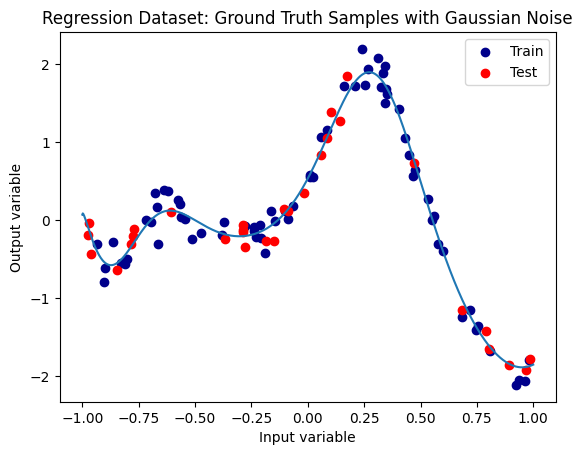

In [46]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)


In [47]:
BNN = FullCovBNN(1, [4, 4], 1, noise_std=0.15)

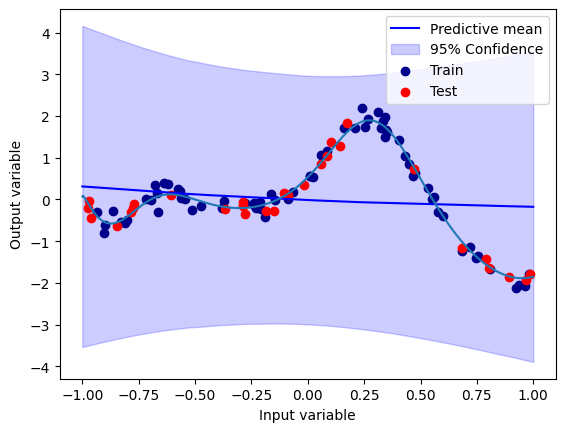

In [48]:
def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_network_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


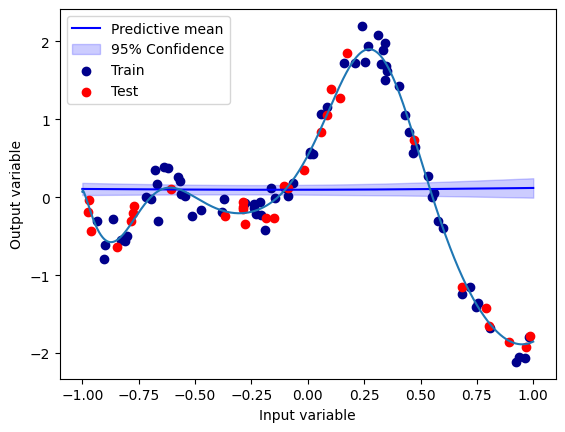

In [49]:
n_epochs = 10

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, 0.15, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

In [28]:
sampled_params = BNN.sample_network_params()  # Sample from q distribution with gradient tracking
input_data = torch.tensor(([0.25]))
BNN.forward(input_data, sampled_params)#.unsqueeze(1)
# input_data

tensor([0.1178], grad_fn=<ViewBackward0>)

In [42]:
sampled_params = BNN.sample_network_params()  # Sample from q distribution with gradient tracking
sampled_params

{0: tensor([-0.4314,  0.7981,  0.2185, -0.0696,  0.3849, -0.2569, -0.2812,  0.9494],
        requires_grad=True),
 1: tensor([-1.1288, -1.3501, -0.3738,  0.6754,  0.9665,  0.6331, -0.4795, -0.9847,
         -0.0220,  1.7638,  0.1505, -0.6581, -0.7288,  0.4167, -0.6793, -0.5261,
         -0.2236, -0.3685, -0.1031, -0.7528], requires_grad=True),
 2: tensor([ 0.0214, -0.0405,  0.0410, -0.0468, -0.0125], requires_grad=True)}

In [15]:
BNN.forward(input_data, sampled_params)


NameError: name 'input_data' is not defined

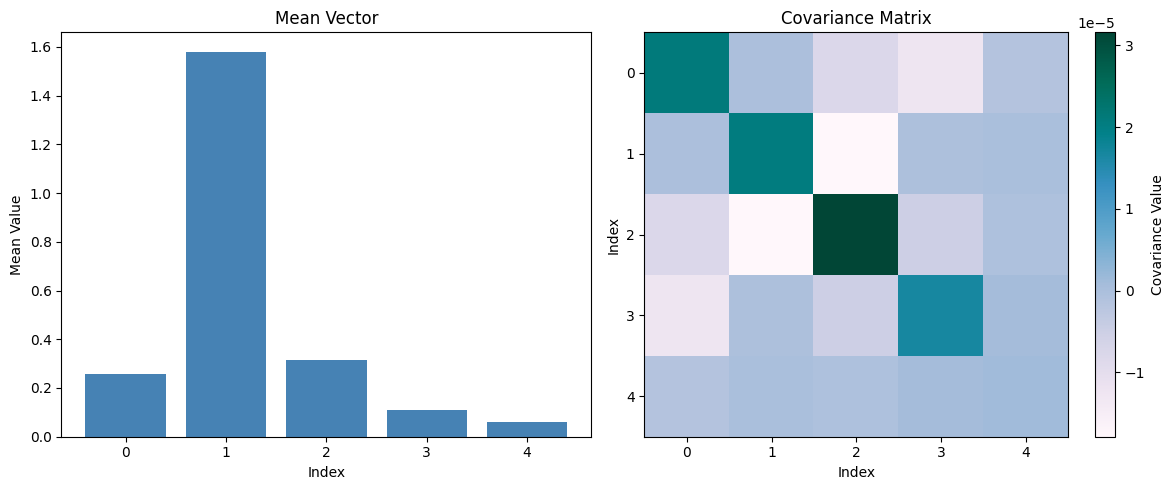

In [158]:
def plot_mean_and_covariance(BNN,layer):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.network[layer].mean)
    cov = to_numpy(BNN.network[layer].cov_chol @ BNN.network[layer].cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].bar(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN,4)


In [97]:
BNN.network[4].cov_chol

tensor([[ 1.3232e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-7.2387e-04,  1.3393e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.7315e-04, -1.9289e-04,  1.5597e-03,  0.0000e+00,  0.0000e+00],
        [-1.5431e-03, -8.2897e-04, -1.4425e-03,  9.0011e-04,  0.0000e+00],
        [-2.7446e-05, -7.4505e-05, -3.5264e-05, -1.6292e-04,  1.4578e-04]])

In [40]:
input_data = torch.tensor(([1.0]), requires_grad=True)
target_data = torch.tensor(([2.0]), requires_grad=True)
BNN = FullCovBNN(1, [2, 2], 1, noise_std=0.15)

In [41]:
update_variational_params_choldate(BNN, input_data, target_data, 0.2, K=1)

sampled params:
{0: tensor([ 0.3970,  0.9257,  1.4252, -0.6912], requires_grad=True), 1: tensor([ 0.6866,  0.0058, -0.6571,  0.2288,  0.0856, -0.5162],
       requires_grad=True), 2: tensor([-1.1221, -0.5267,  0.2450], requires_grad=True)}
gradients:
{0: tensor([58.9237,  2.9135, 60.5303,  0.3870], grad_fn=<DivBackward0>), 1: tensor([325.0795,  41.6985,  14.1828,   2.3144, 177.9417,   7.5400],
       grad_fn=<DivBackward0>), 2: tensor([-319.8368,   38.6331, -237.3079], grad_fn=<DivBackward0>)}
